<a href="https://colab.research.google.com/github/lucas-azdias/OCR-Test/blob/main/Introduction%20to%20OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OCR with Python**

# **Imports & Downloads**

## **Imports**

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pytesseract
import shutil
import sklearn
import tensorflow as tf

from google.colab.patches import cv2_imshow
from IPython.display import display

## **Downloading examples**

In [3]:
!git clone https://github.com/lucas-azdias/OCR-Test.git

Cloning into 'OCR-Test'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 26 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 2.29 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
# Easy way to get examples paths
def get_example(name: str) -> str:
    return f"/content/OCR-Test/examples/{name}"

## **Downloading Tesseract OCR configurations**

In [5]:
os.makedirs("/content/tessdata", exist_ok=True)

!wget -O /content/tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
!wget -O /content/tessdata/eng.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/eng.traineddata?raw=true

--2025-08-23 20:58:13--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/refs/heads/main/por.traineddata [following]
--2025-08-23 20:58:13--  https://github.com/tesseract-ocr/tessdata/raw/refs/heads/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/refs/heads/main/por.traineddata [following]
--2025-08-23 20:58:13--  https://raw.githubusercontent.com/tesseract-ocr/tessdata/refs/heads/main/por.traineddata
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

## **Downloading Kaggle dataset**

In [6]:
kaggle_path = "/content/kaggle"
os.makedirs(kaggle_path, exist_ok=True)

path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset", force_download=True)

!cp -r "{path}/." "{kaggle_path}"

100%|██████████| 13.1M/13.1M [00:00<00:00, 103MB/s]

Extracting files...


# **Pre-processing techiniques**

## **Colour channels**

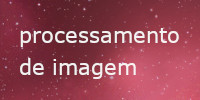

In [ ]:
# Image with 3 colour channels
img = cv2.imread(get_example("images/img-process.jpg"))
cv2_imshow(img)

In [ ]:
img.shape

(100, 200, 3)

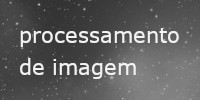

In [ ]:
# Image with only 1 colour channel
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [ ]:
gray.shape

(100, 200)

## **Thresholding**

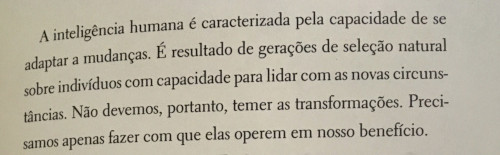

In [ ]:
img = cv2.imread(get_example("images/page-book.jpg"))
cv2_imshow(img)

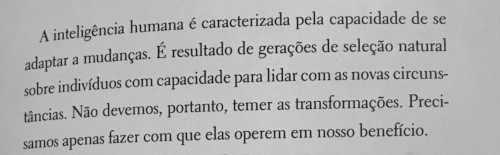

In [ ]:
# Convert image to grey scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

### **Simple threshold**

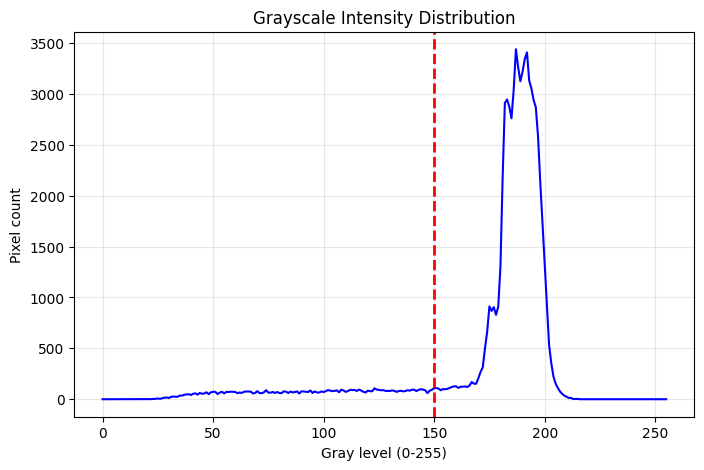

In [ ]:
# Check the distribution of grayscale pixels
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
hist = hist.flatten()

plt.figure(figsize=(8, 5))
plt.plot(range(256), hist, color="blue")
plt.title("Grayscale Intensity Distribution")
plt.xlabel("Gray level (0-255)")
plt.ylabel("Pixel count")
plt.axvline(x=150, color="red", linestyle="--", linewidth=2)
plt.grid(alpha=0.3)
plt.show()

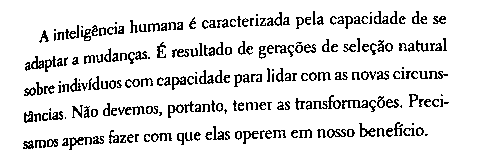

In [ ]:
# Apply threshold to separate background from foreground
value, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
cv2_imshow(thresh)

### **Otsu threshold**

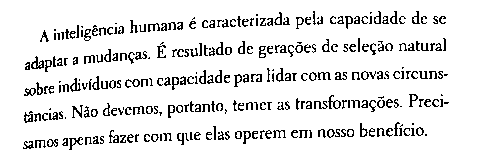

Otsu Threshold Value: 138.0


In [ ]:
# Apply Otsu threshold which calculates the optimal threshold value that
# minimizes the intra-class variance (or equivalently maximizes the
# inter-class variance) between the foreground and background
value, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(otsu)
print(f"Otsu Threshold Value: {value}")

### **Adaptive threshold**

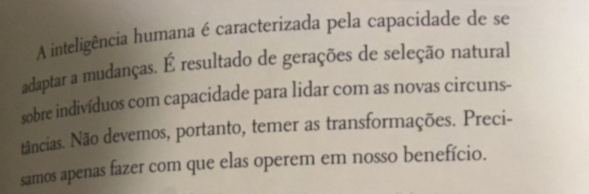

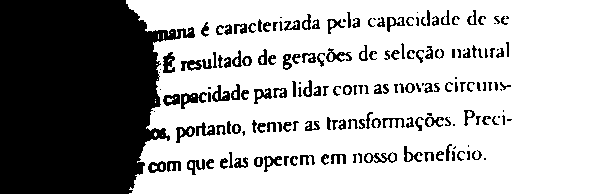

Otsu Threshold Value: 147.0


In [ ]:
# Applying a threshold based on a sharp difference in intensity may
# inadvertently remove regions that should have been preserved
img = cv2.imread(get_example("images/book02.jpg"))
cv2_imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

value, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(otsu)

print(f"Otsu Threshold Value: {value}")

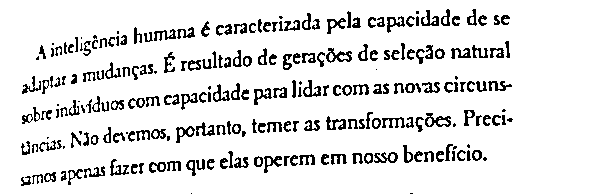

In [ ]:
# Apply adaptive threshold which calculates a threshold for small regions of
# the image (using the mean of the neighborhood) to handle varying lighting
# conditions
adaptive_average = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
cv2_imshow(adaptive_average)

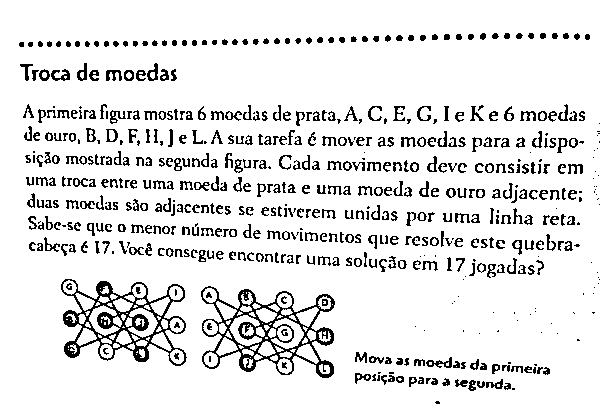

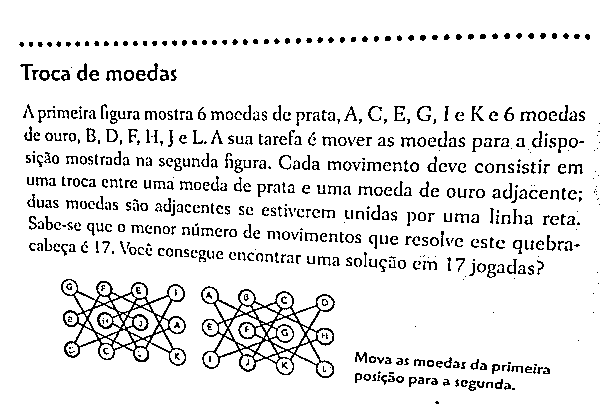

In [ ]:
# Apply adaptive threshold using the gaussian weighted mean of the neighborhood
# which, unlike the mean method, this uses a weighted sum where closer pixels
# to the center have more influence, making it more robust to noise and
# lighting variations
img = cv2.imread(get_example("images/book-adaptive.jpg"))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

adaptive_average = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9)
cv2_imshow(adaptive_average)

adaptive_gaussian = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
cv2_imshow(adaptive_gaussian)

## **Filters**

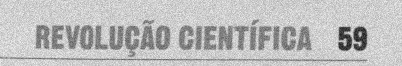

In [ ]:
img = cv2.imread(get_example("images/text-noise.jpg"))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

### **Mean filter**

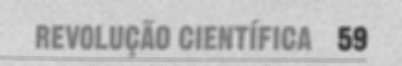

In [ ]:
average_blur = cv2.blur(gray, (5, 5))
cv2_imshow(average_blur)

### **Median filter**

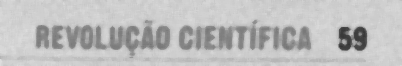

In [ ]:
median_blur = cv2.medianBlur(gray, 5)
cv2_imshow(median_blur)

### **Gaussian filter**

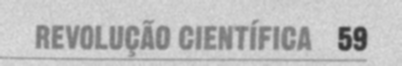

In [ ]:
gaussian_blur = cv2.GaussianBlur(gray, (5, 5), 0)
cv2_imshow(gaussian_blur)

### **Bilateral filter**

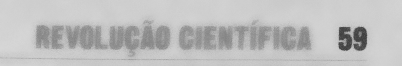

In [ ]:
bilateral_filter = cv2.bilateralFilter(gray, 15, 55, 45)
cv2_imshow(bilateral_filter)

## **Mathematical morphology**

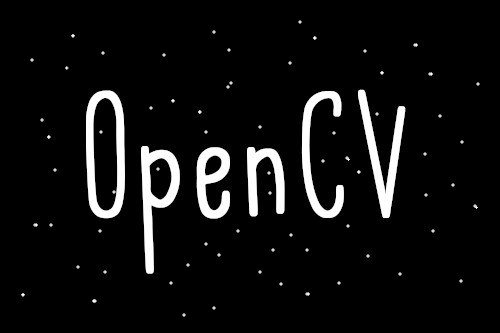

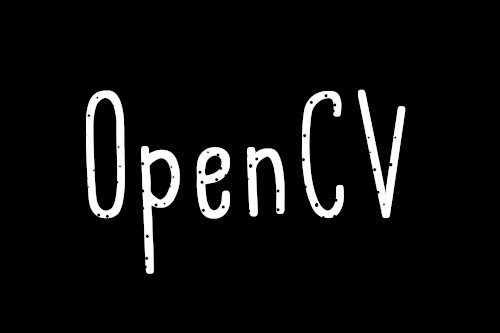

In [ ]:
img1 = cv2.imread(get_example("images/text-opencv01.jpg"))
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray1)

img2 = cv2.imread(get_example("images/text-opencv02.jpg"))
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray2)

In [ ]:
# Kernel
kernel = np.ones((5, 5), np.uint8)

### **Erosion**

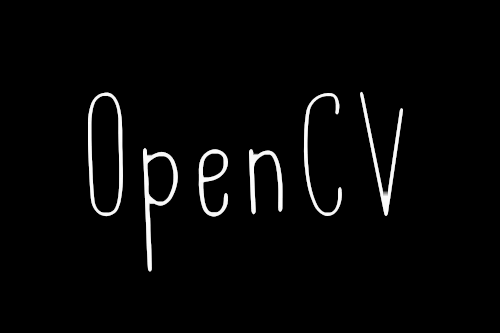

In [ ]:
erosion = cv2.erode(gray1, kernel)
cv2_imshow(erosion)

### **Dilation**

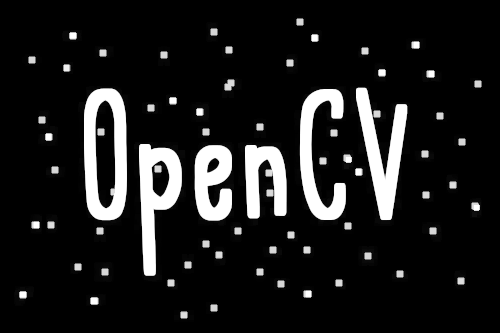

In [ ]:
dilation = cv2.dilate(gray1, kernel)
cv2_imshow(dilation)

### **Opening (Erosion + Dilation)**

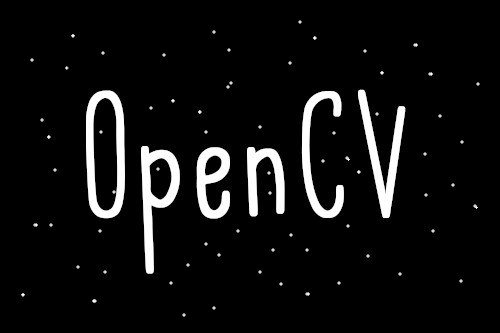

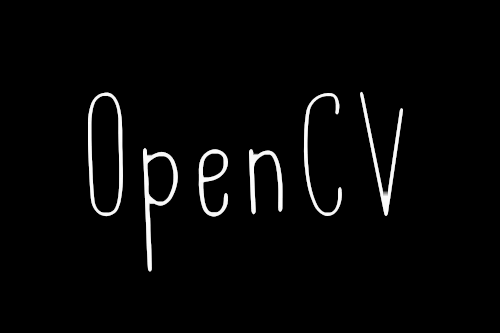

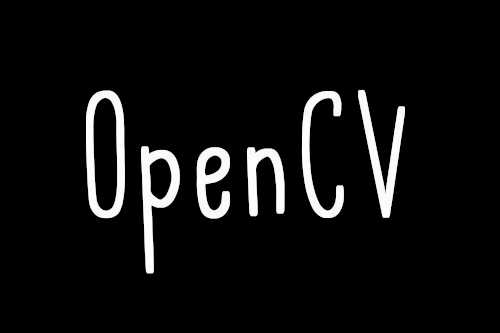

In [ ]:
erosion = cv2.erode(gray1, kernel)
opening = cv2.dilate(erosion, kernel)
cv2_imshow(gray1)
cv2_imshow(erosion)
cv2_imshow(opening)

### **Closing (Dilation + Erosion)**

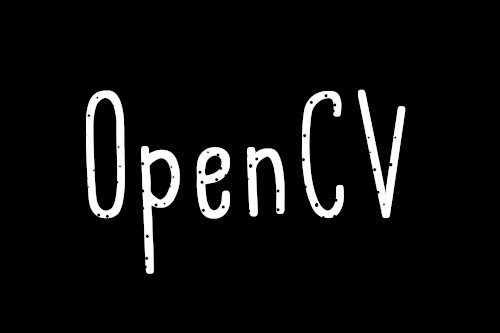

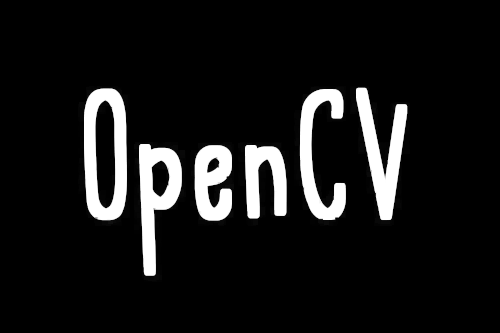

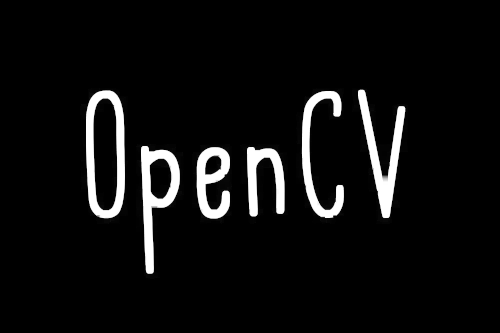

In [ ]:
dilation = cv2.dilate(gray2, kernel)
closing = cv2.erode(dilation, kernel)
cv2_imshow(gray2)
cv2_imshow(dilation)
cv2_imshow(closing)

# **Using Tesseract OCR**

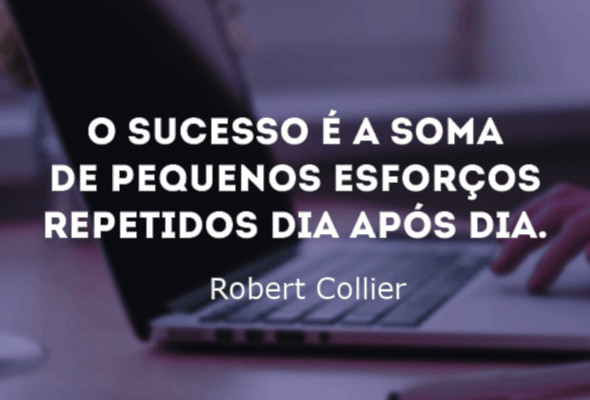

In [ ]:
# Tesseract is an open-source OCR (Optical Character Recognition) engine,
# originally developed by HP and currently maintained by Google
# It uses a LSTM (Long Short-Term Memory)

img = cv2.imread(get_example("images/sentence.jpg"))
cv2_imshow(img)

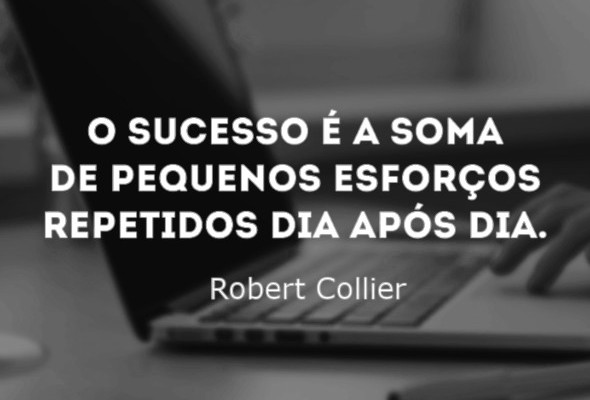

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

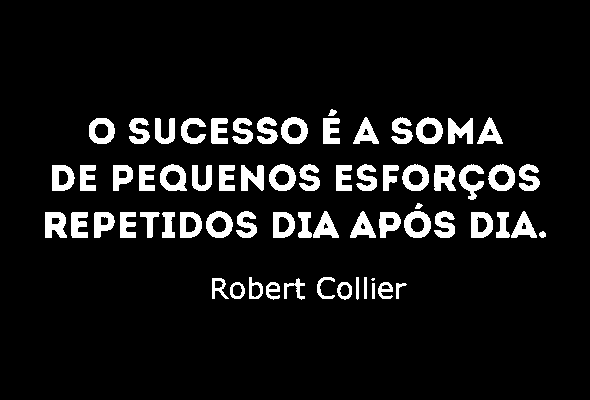

Otsu Threshold Value: 145.0


In [ ]:
value, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2_imshow(thresh)
print(f"Otsu Threshold Value: {value}")

In [ ]:
config_tesseract = "--tessdata-dir tessdata"
text = pytesseract.image_to_string(thresh, lang="por", config=config_tesseract)
print(text)

O SUCESSO É A SOMA
DE PEQUENOS ESFORÇOS
REPETIDOS DIA APÓS DIA.

Robert Collier



# **Custom OCR model**

## **Validating the dataset**

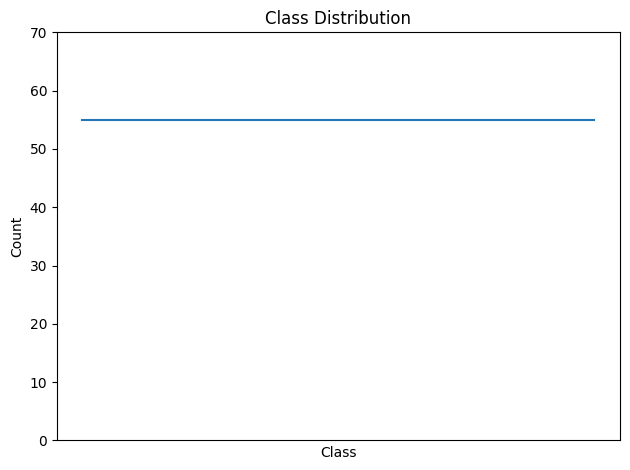

In [7]:
# Get all image files
image_files = [f for f in os.listdir(os.path.join(kaggle_path, "Img"))]

# Get CSV with label mapping
mapping_file = os.path.join(kaggle_path, "english.csv")
mapping_df = pd.read_csv(mapping_file)

# Group by class and count
class_distribution = mapping_df["label"].value_counts().reset_index()

class_distribution.plot(kind="line", x="label", y="count", legend=False)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([])
plt.ylim(0, 70)
plt.tight_layout()
plt.show()

In [8]:
display(class_distribution)

,label,count
0,0,55
1,1,55
2,2,55
3,3,55
4,4,55
...,...,...
57,v,55
58,w,55
59,x,55
60,y,55


## **Loading dataset**

In [70]:
input_shape = (28, 28)

In [71]:
images = []
labels = []

for mask, row in mapping_df.iterrows():
    img_path = os.path.join(kaggle_path, row["image"])

    # Load image
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode="grayscale")
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img.astype(np.uint8)

    # Invert colours
    img = cv2.bitwise_not(img)

    # Crop to content and invert the colours
    img_uint8 = img.astype(np.uint8)
    _, thresh = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    img = img[y:(y + h), x:(x + w)]

    # Resize to 28x28
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)

    # Erosion the outline
    img = cv2.erode(img, np.ones((7, 7), np.uint8))

    # Resize to 28x28
    img = cv2.resize(img, input_shape, interpolation=cv2.INTER_AREA)

    # Normalize to [0, 1]
    img = img / 255.0

    # Append the image and its label
    images.append(img)
    labels.append(row["label"])

images = np.array(images, dtype="float32")
labels = np.array(labels).reshape(-1, 1)

In [72]:
# Encodes the labels as indexes
classes = np.unique(labels.flatten())
class_to_index = {c: i for i, c in enumerate(classes)}
y = np.array([class_to_index[l] for l in labels.flatten()])  # shape: (num_samples,)
num_classes = len(classes)

print(y)
print(num_classes)

[ 0  0  0 ... 61 61 61]
62


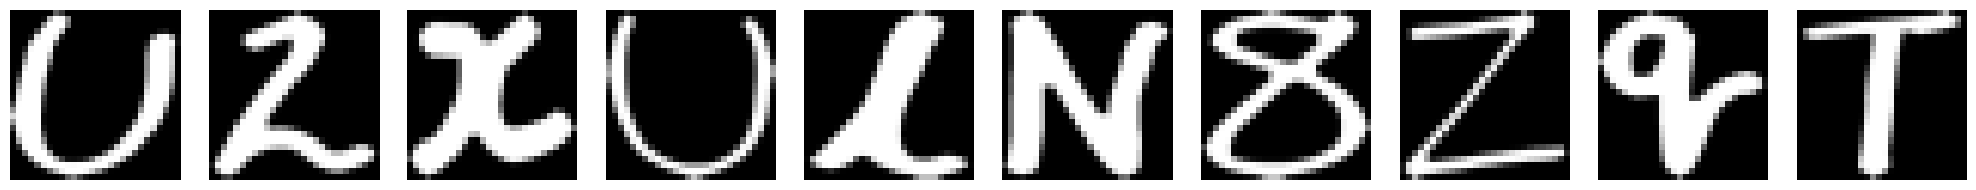

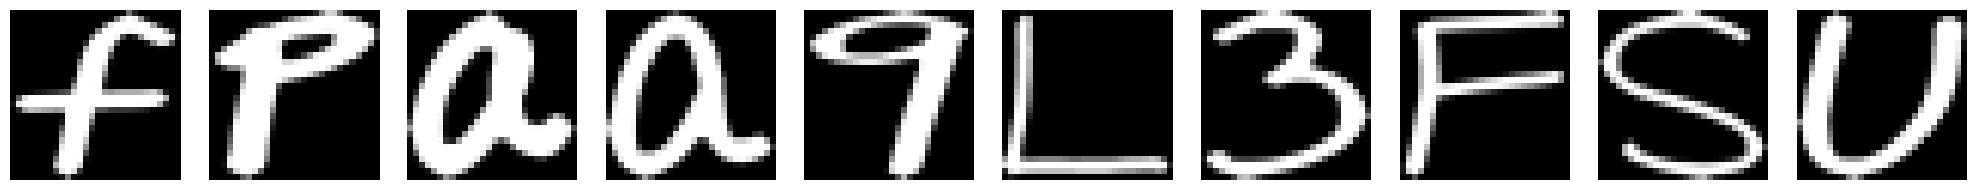

In [73]:
for _ in range(2):
    # Pick 10 random indices
    random_idxs = np.random.choice(len(images), size=10, replace=False)

    # Plot side by side
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for ax, mask in zip(axes, random_idxs):
        ax.imshow(images[mask], cmap="gray")
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

## **Train, validation and test**

In [74]:
test_size = 0.2
validation_size = 0.1

In [75]:
# Split train and validation from test
x_train_val, x_test, y_train_val, y_test = sklearn.model_selection.train_test_split(
    images, y, test_size=test_size, random_state=42, stratify=y
)

# Calculate validation size based on the train and validation size
validation_size_normalized = validation_size / (1 - test_size)

# Split train and validation
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(
    x_train_val, y_train_val, test_size=validation_size_normalized, random_state=42, stratify=y_train_val
)

print(f"x_train: {x_train.shape}", f"x_val: {x_val.shape}", f"x_test: {x_test.shape}", sep="\n")
print()
print(f"y_train: {y_train.shape}", f"y_val: {y_val.shape}", f"y_test: {y_test.shape}", sep="\n")

x_train: (2387, 28, 28)
x_val: (341, 28, 28)
x_test: (682, 28, 28)

y_train: (2387,)
y_val: (341,)
y_test: (682,)


## **Model**

In [94]:
dropout = 0.3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

regularization_factor = 1e-4

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.1),
    ]
)

In [95]:
def create_model():
    model = tf.keras.models.Sequential([
        # Input
        tf.keras.layers.Input(shape=(*input_shape, 1)),

        # Data augmentation
        data_augmentation,

        # Conv block 1
        tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Conv block 2
        tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Conv block last
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Dense
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(regularization_factor)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [96]:
create_model().summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_25 (Sequential)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_96          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_96 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_97 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_98 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_99 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_100         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_100 (Activation)     │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_101         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_101 (Activation)     │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 3, 3, 128)      │             

 Total params: 312,734 (1.19 MB)

 Trainable params: 311,838 (1.19 MB)

 Non-trainable params: 896 (3.50 KB)

### **Model training**

In [97]:
epochs = 100
batch_size = 128

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=False,
    verbose=1
)

In [98]:
model = create_model()

history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[earlystop_cb]
)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.0119 - loss: 4.4388 - val_accuracy: 0.0147 - val_loss: 4.1620
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0319 - loss: 4.1194 - val_accuracy: 0.0147 - val_loss: 4.1654
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0684 - loss: 3.9712 - val_accuracy: 0.0176 - val_loss: 4.1744
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0795 - loss: 3.8912 - val_accuracy: 0.0235 - val_loss: 4.1910
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1113 - loss: 3.7777 - val_accuracy: 0.0176 - val_loss: 4.2163
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1194 - loss: 3.7041 - val_accuracy: 0.0147 - val_loss: 4.2521
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1549 - loss: 3.5987 - val_accuracy: 0.0176 - val_loss: 4.3000
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1601 - loss: 3.5226 - val_accuracy: 0.

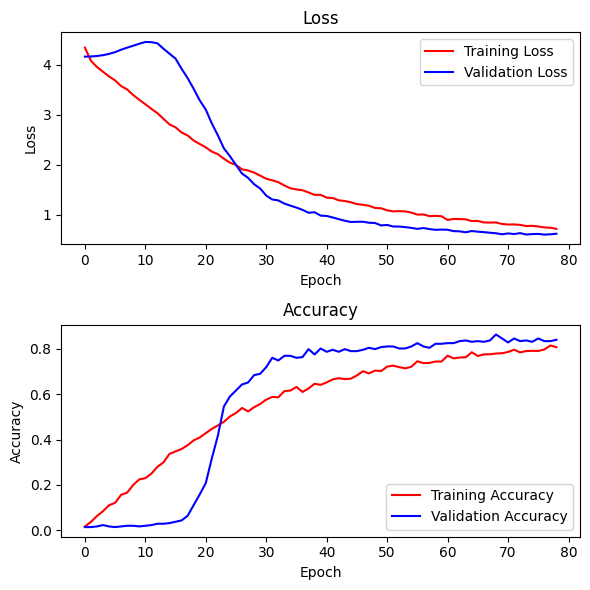

In [99]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))

# Training Loss
ax[0].plot(history.history["loss"], color="r", label="Training Loss")
ax[0].plot(history.history["val_loss"], color="b", label="Validation Loss")
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Training Accuracy
ax[1].plot(history.history["accuracy"], color="r", label="Training Accuracy")
ax[1].plot(history.history["val_accuracy"], color="b", label="Validation Accuracy")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()

### **Model testing**

In [100]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [101]:
report = sklearn.metrics.classification_report(y_test, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.75      0.27      0.40        11
           2       0.77      0.91      0.83        11
           3       0.85      1.00      0.92        11
           4       0.92      1.00      0.96        11
           5       0.71      0.91      0.80        11
           6       1.00      0.91      0.95        11
           7       1.00      0.91      0.95        11
           8       1.00      0.91      0.95        11
           9       0.78      0.64      0.70        11
           A       0.92      1.00      0.96        11
           B       0.92      1.00      0.96        11
           C       0.88      0.64      0.74        11
           D       0.85      1.00      0.92        11
           E       1.00      0.91      0.95        11
           F       0.83      0.91      0.87        11
           G       1.00      1.00      1.00        11
           H       1.00    

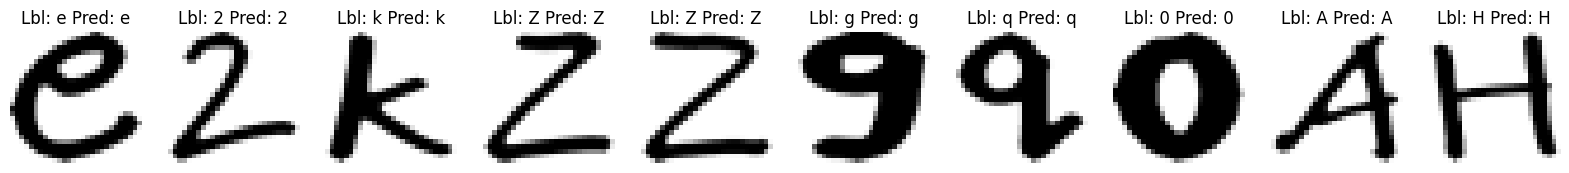

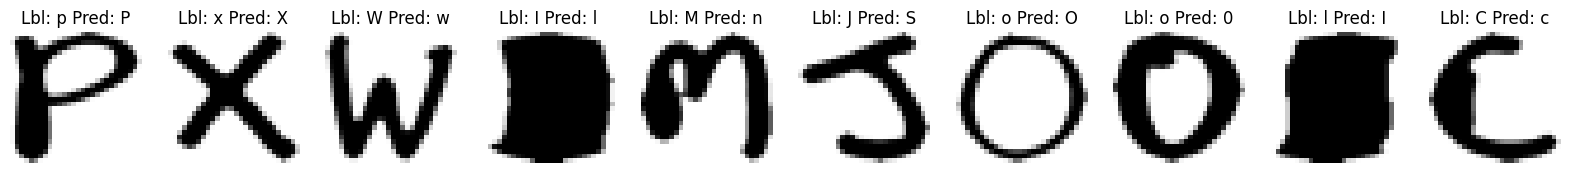

In [102]:
index = np.random.randint(300)
amount = 10
diff = y_test - y_pred

masks = [np.where(diff == 0)[0], np.where(diff != 0)[0]]

for mask in masks:
    valid_indices = mask[mask >= index][:amount]

    _, axes = plt.subplots(nrows=1, ncols=len(valid_indices), figsize=(20, 10))

    if len(valid_indices) == 1:
        axes = [axes]

    for ax, idx in zip(axes, valid_indices):
        ax.set_axis_off()
        ax.imshow(x_test[idx], cmap="gray_r", interpolation="nearest")
        ax.set_title(f"Lbl: {classes[y_test[idx]]} Pred: {classes[y_pred[idx]]}")

plt.show()

**Note:** It is highly probable that the model could reach +90% accuracy, but further improvements are needed.